# Disruptive Science 

*Credit to professor Panagiotis Louridas for originally assigning the project, as well as migrating the data to an easy-to-use SQLite DB.*

A [recent paper in Nature](https://www.nature.com/articles/s41586-022-05543-x) created a stir in the scientific community, arguing that science is becoming less disruptive over time. According to the study, there are fewer groundbreaking papers in recent years. It appears that trailblazers are rare and that most research tends to build and expand existing research rather than opening up new paths of inquiry.

Needless to say, the paper created quite a bit of head-scratching: if science is becoming less disruptive, what, or who, is to blame? Could it be that the low hanging fruits have already been picked? That modern science requires over-specialisation, which entails working within a field of study, rather than exploring new vistas? The discussion raged even in mainstream media like The [Economist](https://www.economist.com/science-and-technology/2023/01/04/papers-and-patents-are-becoming-less-disruptive), The [New York Times](https://www.nytimes.com/2023/01/17/science/science-breakthroughs-disruption.html), [The Atlantic](https://www.theatlantic.com/newsletters/archive/2023/01/academia-research-scientific-papers-progress/672694/); then Nature returned with an [editorial on what it means and whether it matters](https://www.nature.com/articles/d41586-023-00183-1).

## Predicting CD5

Disruption is measured by a metric, [the CD index](http://russellfunk.org/cdindex/), devised by the authors of the study. The CD is calculated over a time window, say five years (then it's called CD5), and it measures how likely is a work that cites a scientific paper to cite the works that paper cites. If follow-up work does not cite a paper's cited predecessors then it's likely that the paper has broken new ground.

The CD index can be calculated for each paper, by finding the works that cite it and the works that the paper itself cites. You can find details in the Nature paper and also in the [original paper that introduced the metric](http://russellfunk.org/cdindex/static/papers/funk_ms_2017.pdf). But then an interesting question arises: is it possible to predict a paper's CD5 index by using only the paper itself, information on its authors, and information on its citations, without looking into the future work that cites it?


## Data Source

The data is derived from the excellent [alexandria3k package](https://github.com/dspinellis/alexandria3k) written by [Professor Diomidis Spinellis](https://www2.dmst.aueb.gr/dds/).In particular, the data comprises part of the [publications graph](https://dspinellis.github.io/alexandria3k/cli-eg.html#publications-graph) for a 1% sample of all CrossRef available publications that have abstracts; an additional table in the database contains the CD5 index for papers. Unfortunately due to its significant size it can't be uploaded, it is however available on request.

This notebook was executed on Python 3.10. The SQL queries used are placed in the `data\sql` subdirectory. The original database file can be found here and must be placed in the `data` subdirectory.

In [1]:
# Install dependencies
!pip install statsmodels
!pip install sklearn
!pip install linearmodels
!pip install matplotlib
!pip install nltk
!pip install numpy
!pip install pandas
!pip install tensorflow
!pip install tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


## Task 1: Data

Our first task is to build a dataframe from the data that resides in a local SQLite database. This means we need to query the database, make the query itself computationally efficient, filter the data and load them into python. We then need to preprocess the data and extract useful features.

In the original paper, the authors identify strong correlations between the CD index of a paper and:
- the diversity of work cited
- the ratio of self-citations to total work cited
- the mean age of work cited
- the dispersion in age of work cited
- the mean age of team members and
- the mean number of prior works produced by team members

### Our SQL database

Most of the background work done to prepare the database and data was done through the [DB Browser for SQLite](https://sqlitebrowser.org/). By looking at the information given to us by the database we decided to use the following pieces of information for each paper:

- The title, to validate the subject/abstract information and for general convinience
- The abstract, whose language and word choice can provide insight about the disruption of a paper, as pointed by the authors of the original paper
- The subjects, as the original paper pointed out differing disruption trends according to the paper's subject
- The publishing date, as the original paper strongly suggests the existence of an inverse relationship between the date and the CD index of a paper
- The existence of self-citations, aka the case where a paper cites another paper written by the same authors (the reason we use a bool instead of a count or mean will be explained later)
- The age of cited works

### Optimizing the database

Our database's size is substantial, at least compared to the computational resources used by a consumer-grade, personal computer. Our query will need to load, combine, and send us all but one tables equaling to atleast 8GB of data. 

In order to make the query efficient we will build indexes (and where applicable *unique* indexes) on all keys used in our tables. This substantially cuts down the time to execute the query. The databased provided with this notebook already contains the built indexes, but we also have included the index creation commands in `data\sql\set_up_indexes.sql` for reproducibility.

In [1]:
import sqlite3 as sql
from time import time

with open("data/sql/set_up_indexes.sql", "r") as index_file:
    index_query = index_file.read()

con = sql.connect("data/publications_graph.db")
cur = con.cursor()

# Indexes significantly speed up the query but may take a couple of minutes to be created,
# feel free to comment this out
try:
    print("Creating indexes...")
    start_time = time()
    cur.executescript(index_query)
    print(f"Indexes created in {(time() - start_time)/60 :.3f} minutes.")
except sql.OperationalError:
    print("Indexes already created, skipping...")

Creating indexes...
Indexes already created, skipping...


### Fetching the data

The query used to fetch the data can be found in `data\sql\get_papers.sql`. It combines all tables but `author_affiliations`, groups the papers by doi, checks whether each paper has a self-citation and calculates the mean / variance of the age of cited works. 

Note that we make use of the `GROUP_CONCAT` aggregation function provided by SQLite in order to reduce the count of columns from about 220 million to just about 46,000. Implementation details are described in the SQL file itself.

We fetch the data and place them in a pandas dataframe, using the "doi" column as index:

In [3]:
import pandas as pd

with open("data/sql/get_papers.sql", "r") as query_file:
    query = query_file.read()
    
global_start = time()

start_time = time()
print("Loading data from local database...")
data_df = pd.read_sql(query, con, "doi")
print(f"Fetched {len(data_df)} documents in {time() - start_time:.3f} seconds.")

# close database connection since we already have all our data
con.close()

data_df

Loading data from local database...
Fetched 46159 documents in 72.124 seconds.


,abstract,title,year,month,day,subjects,xrefs,xref_mean_age,xref_var_age,self_cited,cd
doi,,,,,,,,,,,
10.1002/bjs.10032,<jats:title>Abstract</jats:title>\n ...,Health-related quality of life after pancreati...,2015,11.0,19.0,Surgery|Surgery|Surgery|Surgery|Surgery|Surger...,10.1016/0277-9536(91)90156-7|10.1097/00005650-...,6110.223514,5.550178e+06,0,-0.001182
10.1002/bjs.10224,<jats:title>Abstract</jats:title>\n ...,Comparison of three targeted approaches to scr...,2016,7.0,18.0,Surgery|Surgery|Surgery|Surgery|Surgery|Surger...,10.1001/archinte.160.10.1425|10.1016/s0021-915...,4706.242994,2.949473e+06,0,-0.015896
10.1002/bjs.10275,<jats:title>Abstract</jats:title>\n ...,Multicentre observational study of surgical sy...,2016,8.0,25.0,Surgery|Surgery|Surgery|Surgery|Surgery|Surger...,10.1056/nejm199102073240605|10.1016/s0140-6736...,5789.113624,5.734684e+06,0,0.000087
10.1002/bjs.10585,<jats:p>Centralization may prove essential</ja...,Improving care for patients with pancreatitis,2017,6.0,27.0,Surgery|Surgery|Surgery|Surgery|Surgery|Surger...,10.1053/j.gastro.2008.11.044|10.1097/sla.0b013...,3271.652085,7.683254e+05,0,-0.003393
10.1002/bjs.10674,<jats:title>Abstract</jats:title>\n ...,Meta-analysis of the association between alcoh...,2017,9.0,7.0,Surgery|Surgery|Surgery|Surgery|Surgery|Surger...,10.1016/0197-2456(86)90046-2|10.1093/jnci/80.1...,5800.807257,7.138988e+06,0,-0.000077
...,...,...,...,...,...,...,...,...,...,...,...
10.7739/jkafn.2020.27.3.226,<jats:p>Purpose: The purpose of this study was...,Factors Influencing Depression: Comparison acc...,2020,8.0,31.0,General Nursing|General Nursing|General Nursin...,None,2443.718752,6.202149e+05,0,0.000000
10.7739/jkafn.2020.27.3.310,<jats:p>Purpose: The purpose of this study was...,Risk Factors affecting Dyslipidemia according ...,2020,8.0,31.0,General Nursing|General Nursing|General Nursin...,None,2492.540974,6.227445e+05,0,0.000000
10.7785/tcrt.2012.500265,<jats:p> Radiation therapy is prescribed to mo...,Vascular Strategies for Enhancing Tumour Respo...,2012,10.0,NaN,Cancer Research|Cancer Research|Cancer Researc...,10.7863/jum.2010.29.4.597|10.7863/jum.2010.29....,8366.985418,1.152022e+07,0,-0.002440


We remove data with no information on the cited works (since it would be erroneous to use a sentinel value for the missing fields).

In [4]:
nan_rows = (data_df.xref_mean_age.isnull() 
            | data_df.xref_var_age.isnull()
            | (data_df.xref_mean_age < 0) 
            | (data_df.xref_var_age < 0))
data_df = data_df[~nan_rows]
data_df

,abstract,title,year,month,day,subjects,xrefs,xref_mean_age,xref_var_age,self_cited,cd
doi,,,,,,,,,,,
10.1002/bjs.10032,<jats:title>Abstract</jats:title>\n ...,Health-related quality of life after pancreati...,2015,11.0,19.0,Surgery|Surgery|Surgery|Surgery|Surgery|Surger...,10.1016/0277-9536(91)90156-7|10.1097/00005650-...,6110.223514,5.550178e+06,0,-0.001182
10.1002/bjs.10224,<jats:title>Abstract</jats:title>\n ...,Comparison of three targeted approaches to scr...,2016,7.0,18.0,Surgery|Surgery|Surgery|Surgery|Surgery|Surger...,10.1001/archinte.160.10.1425|10.1016/s0021-915...,4706.242994,2.949473e+06,0,-0.015896
10.1002/bjs.10275,<jats:title>Abstract</jats:title>\n ...,Multicentre observational study of surgical sy...,2016,8.0,25.0,Surgery|Surgery|Surgery|Surgery|Surgery|Surger...,10.1056/nejm199102073240605|10.1016/s0140-6736...,5789.113624,5.734684e+06,0,0.000087
10.1002/bjs.10585,<jats:p>Centralization may prove essential</ja...,Improving care for patients with pancreatitis,2017,6.0,27.0,Surgery|Surgery|Surgery|Surgery|Surgery|Surger...,10.1053/j.gastro.2008.11.044|10.1097/sla.0b013...,3271.652085,7.683254e+05,0,-0.003393
10.1002/bjs.10674,<jats:title>Abstract</jats:title>\n ...,Meta-analysis of the association between alcoh...,2017,9.0,7.0,Surgery|Surgery|Surgery|Surgery|Surgery|Surger...,10.1016/0197-2456(86)90046-2|10.1093/jnci/80.1...,5800.807257,7.138988e+06,0,-0.000077
...,...,...,...,...,...,...,...,...,...,...,...
10.7739/jkafn.2020.27.3.226,<jats:p>Purpose: The purpose of this study was...,Factors Influencing Depression: Comparison acc...,2020,8.0,31.0,General Nursing|General Nursing|General Nursin...,None,2443.718752,6.202149e+05,0,0.000000
10.7739/jkafn.2020.27.3.310,<jats:p>Purpose: The purpose of this study was...,Risk Factors affecting Dyslipidemia according ...,2020,8.0,31.0,General Nursing|General Nursing|General Nursin...,None,2492.540974,6.227445e+05,0,0.000000
10.7785/tcrt.2012.500265,<jats:p> Radiation therapy is prescribed to mo...,Vascular Strategies for Enhancing Tumour Respo...,2012,10.0,NaN,Cancer Research|Cancer Research|Cancer Researc...,10.7863/jum.2010.29.4.597|10.7863/jum.2010.29....,8366.985418,1.152022e+07,0,-0.002440


### Preproccessing

We will start by preprocessing the texts in the abstracts, which are the only document-like data in our dataset. We should convert these texts to lowercase, remove common stopwords and turnucate whitespace.

First of all we will use the NLTK corpus to download English stopwords.

In [5]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
cachedStopWords = set(stopwords.words("english"))
cachedStopWords.add("abstract")
cachedStopWords.add("abstract\n")
len(cachedStopWords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


181

We will now use the built-in regex python library to remove the above stopwords, punctuation marks, numbers and html/jats tags.

In [6]:
import re
    
# set compiled patterns as global to avoid compilation overhead
# remove stopwords, numbers, punctuation and html-like tags
_RE_REMOVE_STOPWORDS = re.compile(r'\b(' + r'|'.join(cachedStopWords) + r')\b' + r"|<[^>]+>" 
                                  + r"|\d+" + r'|[?|$|.|!|;|%|/|\(|\)|\[|\]|=|+|-|,]')
_RE_COMBINE_WHITESPACE = re.compile(r"\s+")

def filter_abstract(abstract: str) -> str:
    abstract = abstract.lower()
    abstract = _RE_REMOVE_STOPWORDS.sub("", abstract)
    abstract = _RE_COMBINE_WHITESPACE.sub(" ", abstract).strip()
    return abstract

random_paper = data_df.iloc[4567]
filter_abstract(random_paper.abstract)

'triazines one widely used herbicide classes ever developed critical managing weed populations developed herbicide resistance herbicides traditionally valued residual weed control crops scientific literature suggests atrazine perhaps -triazines may longer remain persistent soils due enhanced microbial degradation experiments examined rate degradation atrazine two triazine herbicides simazine metribuzin atrazine-adapted non-history corn belt soils similar soils used state comparison potential triazine degradation three soils history atrazine use atrazine least four times greater three soils history atrazine use simazine degradation three sets soils times rapid history soils non-history soils metribuzin history soils degraded times rate seen three non-history soils results indicate enhanced degradation symmetrical triazine simazine asymmetrical triazine metribuzin'

An unfortunate downside of how we structured our query is that there are many duplicate elements for each of the joined tables. We should remove these duplicates from our list-like strings in the dataset.

In [7]:
def remove_duplicates(x: str) -> str:
    if x is None:
        return ""
    else:
        return " ".join(set(x.split("|")))

We can now build our preproccessed dataset:

In [8]:
df = pd.DataFrame({"title": data_df.title,
                "abstract": data_df.abstract.apply(filter_abstract),
                "subjects": data_df.subjects.apply(remove_duplicates),
                "crossrefs": data_df.xrefs.apply(remove_duplicates),
                "date": pd.to_datetime(
                    dict(year=data_df.year, month=data_df.month.fillna(1), day=data_df.day.fillna(1))),
                "crossref_mean_age": data_df.xref_mean_age,
                "crossref_var_age": data_df.xref_var_age,
                "self_cited": data_df.self_cited,
                "cd": data_df.cd})

df

,title,abstract,subjects,crossrefs,date,crossref_mean_age,crossref_var_age,self_cited,cd
doi,,,,,,,,,
10.1002/bjs.10032,Health-related quality of life after pancreati...,background health-related quality life qol maj...,Surgery,10.1016/j.surg.2005.05.001 10.1007/s11605-009-...,2015-11-19,6110.223514,5.550178e+06,0,-0.001182
10.1002/bjs.10224,Comparison of three targeted approaches to scr...,background abdominal aortic aneurysm aaa conti...,Surgery,10.1136/bmj.b2307 10.1161/circulationaha.111.0...,2016-07-18,4706.242994,2.949473e+06,0,-0.015896
10.1002/bjs.10275,Multicentre observational study of surgical sy...,background vascular surgical care changed dram...,Surgery,10.1016/s0140-6736(99)01075-2 10.1016/j.jvs.20...,2016-08-25,5789.113624,5.734684e+06,0,0.000087
10.1002/bjs.10585,Improving care for patients with pancreatitis,centralization may prove essential,Surgery,10.1053/j.gastro.2008.11.044 10.1016/j.pan.201...,2017-06-27,3271.652085,7.683254e+05,0,-0.003393
10.1002/bjs.10674,Meta-analysis of the association between alcoh...,background alcohol possible risk factor abdomi...,Surgery,10.1016/0197-2456(86)90046-2 10.1016/j.atheros...,2017-09-07,5800.807257,7.138988e+06,0,-0.000077
...,...,...,...,...,...,...,...,...,...
10.7739/jkafn.2020.27.3.226,Factors Influencing Depression: Comparison acc...,purpose: purpose study compare factors influen...,General Nursing,,2020-08-31,2443.718752,6.202149e+05,0,0.000000
10.7739/jkafn.2020.27.3.310,Risk Factors affecting Dyslipidemia according ...,purpose: purpose study investigate risk factor...,General Nursing,,2020-08-31,2492.540974,6.227445e+05,0,0.000000
10.7785/tcrt.2012.500265,Vascular Strategies for Enhancing Tumour Respo...,radiation therapy prescribed patients diagnose...,Cancer Research Oncology,10.7863/jum.2010.29.4.597,2012-10-01,8366.985418,1.152022e+07,0,-0.002440


Let's also quickly check whether our preproccessed abstracts and self citation columns are valid

In [9]:
records_without_abstract = df.abstract.apply(lambda x : x.isspace())
df[records_without_abstract]

,title,abstract,subjects,crossrefs,date,crossref_mean_age,crossref_var_age,self_cited,cd
doi,,,,,,,,,


In [10]:
df[df.self_cited != 0]

,title,abstract,subjects,crossrefs,date,crossref_mean_age,crossref_var_age,self_cited,cd
doi,,,,,,,,,
10.1002/bjs.4138,Protection against experimental small intestin...,background intestinal ischaemia–reperfusion ir...,Surgery,10.1097/00000658-200107000-00015 10.1016/0140-...,2003-06-05,10206.294942,4.529483e+06,1,-0.004027
10.1002/bjs.4277,Origin of symptoms in diverticular disease,background significant number patients colonic...,Surgery,10.1007/bf02049475 10.1136/gut.29.2.218 10.113...,2003-08-01,13281.344998,1.994244e+07,1,-0.005741
10.1002/pmj.20180,Polar Expedition Project and Project Management,article presents results polar expedition sea ...,Management of Technology and Innovation Busine...,,2010-06-01,9790.299144,1.399811e+07,1,0.000000
10.1002/pmj.21322,Managing the Intangible Aspects of a Project: ...,successful projects often characterized unique...,Management of Technology and Innovation Busine...,,2013-02-01,10223.679863,1.476032e+07,1,0.000135
10.1002/pmj.21407,"Interactions between Organizational Culture, T...",research used multiple-case study approach emp...,Management of Technology and Innovation Busine...,,2014-04-01,8242.470267,1.028090e+07,1,0.000194
...,...,...,...,...,...,...,...,...,...
10.7554/elife.26174,Exophilin-8 assembles secretory granules for e...,exophilin- reported play role anchoring secret...,"General Biochemistry, Genetics and Molecular B...",10.1074/jbc.m212341200 10.1016/j.celrep.2014.1...,2017-07-04,6736.348514,7.865104e+06,1,-0.004240
10.7554/elife.38173,CaImAn an open source tool for scalable calciu...,advances fluorescence microscopy enable monito...,"General Biochemistry, Genetics and Molecular B...",10.1038/nmeth.3217 10.1523/jneurosci.2744-15.2...,2019-01-17,3443.036700,2.633133e+06,1,-0.025103
10.7554/elife.47791,Cytoplasmic protein misfolding titrates Hsp70 ...,hsf ancient transcription factor responds prot...,"General Biochemistry, Genetics and Molecular B...",10.1016/j.cell.2014.05.045 10.1091/mbc.12.2.32...,2019-09-25,6767.857213,1.468905e+07,1,-0.000503


### Limitations

An issue we will need to deal with is the fact that the dataset only contains 1% of the data used in the original paper. Besides having to work with a relatively small sample, this also means that while for each paper we have the doi of all the works it cites, we will on average have only information about only 1% of those citations. 

To demonstrate this fact, let's select the references of a random paper and see how many of them exist in our dataset: 

In [11]:
doi = "10.7554/elife.50223"
xrefs = df.loc[doi].crossrefs
print(len(remove_duplicates(xrefs).split(" ")))
existing_xrefs = [xref for xref in xrefs.split(" ") if xref in df.index]
existing_xrefs

70


[]

Let's now apply the same method to each paper in our dataset:

In [12]:
xrefs = df.crossrefs
existing_xrefs = xrefs.apply(lambda xrefs: 
                             len([set(xref) for xref in xrefs.split(" ") if xref in df.index]) 
                             if xrefs is not None else [])

In [13]:
existing_xrefs.mean()

0.020588559462140416

In [14]:
existing_xrefs.apply(lambda x: x != 0).sum()

868

As we can see, the average paper cites 0.2 papers that exist in our dataset and only about 870 of the 45319 papers even have *any* citations that exist in our dataset.

This means that instead of calculating the mean number of self-citations, as was the case in the original paper, we may need to just check if any of the citations that exist in our dataset are self citations. This would necessarily be a very noisy indicator, but may be better than nothing.

We also don't have any information about the researchers other than their affiliation (which shouldn't be a useful descriptor of the CD5 index). 

## Task 2: Linear Regression

We will attempt to use whatever information we were able to gather to train an ordinary-least-squares model that can predict the CD5 index of a paper. We choose the OLS model as it is a simple and usually sufficient regression model, and the one used in the original paper (albeit with different data).

### Extracting data from the subject's text

We will begin by acquiring the TF-IDF weight for each word in the paper's subjects. We won't make use of much of the preprocessing capabilities of the TFidfVectorizer class, as we have preproccessed the dataset ourselves. 

We will also take into account all tokens on the subject column as they generally have a very small number of words and thus processing time is not an issue.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

print("Extracting tf-idf features...")
tf_vectorizer = TfidfVectorizer(strip_accents='unicode',
                                use_idf=True)
start_time = time()
tf = tf_vectorizer.fit_transform(df.subjects)
print("Done in %0.3fs." % (time() - start_time))
print(tf.shape)

Extracting tf-idf features...
Done in 0.409s.
(45365, 361)


We will now extract each paper's subject. To do so we will use Latent Dirichet Allocation, a fuzzy, unsupervised, clustering algorithm. In partical terms it calculates the chance of each document belonging in one of many possible "Topics" (in our case scientific subjects).

These topics were classified in the original paper as "Physical Sciences", "Life sciences and biomedicine", "Social sciences" and "Technology". Our first idea would be to use 4 topics that hopefully correspond to the above classifications.

In [16]:
from sklearn.decomposition import LatentDirichletAllocation


def create_fit_lda_model(tf: object, n_topics: int) -> LatentDirichletAllocation:
    print(f"Fitting LDA model with TF-IDF features and {n_topics} topics...")
    
    lda = LatentDirichletAllocation(n_components=n_topics, 
                                    learning_method="online", # use online learning because of the small dataset
                                    random_state=42)
    
    start_time = time()
    lda.fit(tf)
    print("Done in %0.3fs." % (time() - start_time))
    return lda

In [17]:
def print_topic_words(lda: LatentDirichletAllocation, tf_vectorizer: object, n_top_words: int=10) -> None:
    # gracefully stolen code
    tf_feature_names = tf_vectorizer.get_feature_names_out()
    
    print("Topics in the LDA model:")
    for topic_idx, topic in enumerate(lda.components_):
        print(f"Topic {topic_idx}")
        sorted_topics_indcs = (-topic).argsort()[:n_top_words]
        feature_names = [ tf_feature_names[i] for i in sorted_topics_indcs ]
        feature_counts = topic[sorted_topics_indcs]
        print(" ".join([ f'{fn} {fc:.2f}' for fn, fc in zip(feature_names, feature_counts)]))

In [18]:
model_4 = create_fit_lda_model(tf, 4)
print_topic_words(model_4, tf_vectorizer)

Fitting LDA model with TF-IDF features and 4 topics...
Done in 41.721s.
Topics in the LDA model:
Topic 0
medicine 2914.87 general 2212.48 biology 1601.13 molecular 1255.49 biochemistry 1247.14 genetics 997.15 microbiology 759.41 cell 688.79 immunology 688.67 medical 650.55
Topic 1
and 1284.77 computer 1087.37 science 1024.36 general 995.61 miscellaneous 950.23 psychology 863.12 education 844.56 structural 842.52 sciences 836.27 civil 812.11
Topic 2
multidisciplinary 1504.78 management 770.66 and 732.59 political 574.71 sociology 470.34 surgery 451.08 policy 450.89 oncology 435.46 development 414.99 law 401.79
Topic 3
engineering 2728.20 and 1961.01 chemistry 1677.65 science 1537.17 general 1378.02 health 1183.57 materials 1078.85 mechanical 1047.62 physics 814.51 environmental 659.20


The algorithm seems to mostly agree with the subjects. By inspecting the top words for each topics we can infer that:
- Topic 0 is clinical medicine
- Topic 1 is technology
- Topic 3 is physical sciences 
- Topic 2 essentially is everything else.

We could explore the use of a different cluster hyperparameter to see if the model can more accurately split the topics:

In [19]:
model_3 = create_fit_lda_model(tf, 3)
print_topic_words(model_3, tf_vectorizer)

Fitting LDA model with TF-IDF features and 3 topics...
Done in 39.630s.
Topics in the LDA model:
Topic 0
medicine 2922.31 general 2497.66 biology 1601.20 molecular 1255.52 biochemistry 1247.17 and 1107.97 genetics 997.23 immunology 868.16 microbiology 842.27 cell 688.87
Topic 1
engineering 2728.29 and 2171.83 health 1762.94 science 1688.73 chemistry 1677.70 general 1594.67 materials 1078.93 mechanical 1047.71 structural 842.62 mathematics 831.79
Topic 2
multidisciplinary 1504.86 and 1306.84 science 1225.02 miscellaneous 1107.51 computer 1087.42 psychology 863.18 education 844.64 management 770.73 applications 642.85 history 632.77


In [20]:
model_5 = create_fit_lda_model(tf, 5)
print_topic_words(model_5, tf_vectorizer)

Fitting LDA model with TF-IDF features and 5 topics...
Done in 41.626s.
Topics in the LDA model:
Topic 0
biology 1601.09 molecular 1255.46 biochemistry 1247.12 genetics 997.11 microbiology 728.56 cell 688.74 general 660.58 medical 650.50 pharmacology 554.23 medicine 508.79
Topic 1
engineering 1909.51 and 1503.19 computer 1087.32 science 991.17 mechanical 945.52 psychology 863.07 education 844.52 structural 842.49 civil 812.08 applications 642.80
Topic 2
multidisciplinary 1504.73 management 770.61 energy 522.65 surgery 451.04 policy 437.85 and 437.59 law 399.88 environment 297.53 the 297.53 sustainability 297.53
Topic 3
general 2610.64 medicine 2188.57 chemistry 1677.60 science 1398.87 and 1303.55 health 1256.93 materials 1009.18 engineering 818.86 physics 814.46 environmental 758.32
Topic 4
miscellaneous 1278.88 and 897.84 immunology 867.98 mathematics 852.08 sciences 836.22 general 810.44 social 488.14 applied 481.60 planetary 436.77 oncology 435.42


We can see that attempting to split to 3 or 5 topics leads to decreasing coherency among the topics. We will thus use 4 clusters.

Now we can assign the probability of each paper belonging to a certain topic.

In [21]:
lda_model = model_4

In [22]:
doc_topic = lda_model.transform(tf)
doc_topic.shape

(45365, 4)

In [23]:
topic_names = ["topic" + str(index) for index in range(doc_topic.shape[1])]
topic_df = pd.DataFrame(doc_topic, columns=topic_names)
topic_df.index = df.index
topic_df

,topic0,topic1,topic2,topic3
doi,,,,
10.1002/bjs.10032,0.125000,0.125000,0.625000,0.125000
10.1002/bjs.10224,0.125000,0.125000,0.625000,0.125000
10.1002/bjs.10275,0.125000,0.125000,0.625000,0.125000
10.1002/bjs.10585,0.125000,0.125000,0.625000,0.125000
10.1002/bjs.10674,0.125000,0.125000,0.625000,0.125000
...,...,...,...,...
10.7739/jkafn.2020.27.3.226,0.671633,0.109770,0.108814,0.109784
10.7739/jkafn.2020.27.3.310,0.671633,0.109770,0.108814,0.109784
10.7785/tcrt.2012.500265,0.091528,0.091528,0.725415,0.091528


In order to feed the published date in our model, we need to convert it into a number. The best way to represent this is by using the *ordinal* date, aka an int representing the days passed since the 1st day of the 1st year. 

In [24]:
feature_df = pd.DataFrame({"ordinal_date":  df.date.apply(lambda x: x.toordinal()),
                           "self_citation": df.self_cited,
                           "crossref_mean_age": df.crossref_mean_age,
                           "crossref_var_age": df.crossref_var_age,
                           "cd5": df.cd})
feature_df = feature_df.join(topic_df)

feature_df

,ordinal_date,self_citation,crossref_mean_age,crossref_var_age,cd5,topic0,topic1,topic2,topic3
doi,,,,,,,,,
10.1002/bjs.10032,735921,0,6110.223514,5.550178e+06,-0.001182,0.125000,0.125000,0.625000,0.125000
10.1002/bjs.10224,736163,0,4706.242994,2.949473e+06,-0.015896,0.125000,0.125000,0.625000,0.125000
10.1002/bjs.10275,736201,0,5789.113624,5.734684e+06,0.000087,0.125000,0.125000,0.625000,0.125000
10.1002/bjs.10585,736507,0,3271.652085,7.683254e+05,-0.003393,0.125000,0.125000,0.625000,0.125000
10.1002/bjs.10674,736579,0,5800.807257,7.138988e+06,-0.000077,0.125000,0.125000,0.625000,0.125000
...,...,...,...,...,...,...,...,...,...
10.7739/jkafn.2020.27.3.226,737668,0,2443.718752,6.202149e+05,0.000000,0.671633,0.109770,0.108814,0.109784
10.7739/jkafn.2020.27.3.310,737668,0,2492.540974,6.227445e+05,0.000000,0.671633,0.109770,0.108814,0.109784
10.7785/tcrt.2012.500265,734777,0,8366.985418,1.152022e+07,-0.002440,0.091528,0.091528,0.725415,0.091528


### Validating the data

Before we build our model, we should take take care of colinearity issues between our variables. We will do so by calculating the VIF (Variance Inflation Factor) score of each variable in our dataset and discarding variables with a score larger than 5, very common threshold.

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_vif(df: pd.DataFrame) -> pd.DataFrame:
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i)
                              for i in range(len(df.columns))]
    return vif_data

get_vif(feature_df)

,feature,VIF
0,ordinal_date,1.883753
1,self_citation,1.080706
2,crossref_mean_age,2.070085
3,crossref_var_age,1.207311
4,cd5,1.050356
5,topic0,10173.376952
6,topic1,10738.456849
7,topic2,5700.800433
8,topic3,13290.052072


It's natural that the topic variables have a significant VIF score since they represent a probability distribution (and thus their sum is always 1). We can solve this problem by simply omitting one of the topic variables. 

In [26]:
temp_df = feature_df.iloc[:, 0:8]
get_vif(temp_df)

,feature,VIF
0,ordinal_date,9.521727
1,self_citation,1.070550
2,crossref_mean_age,4.045102
3,crossref_var_age,1.142947
4,cd5,1.033187
5,topic0,2.651296
6,topic1,2.840153
7,topic2,2.152757


The ordinal date is the only variable eligible for removal from our feature dataset. We will keep it however, as it proves essential for our model.

The reason why we don't standardize any of our data before feeding it into our model is because standardizing variables in OLS regression is [inadvisable in most circumstances](https://www.listendata.com/2017/04/how-to-standardize-variable-in-regression.html). This holds true especially for [categorical and ordinal variables](https://stats.stackexchange.com/a/385538).

We considered centering the `crossref_mean_age` and `crossref_var_age` variables since centering variables that interact with each other is supposed to remove some colinearity. [This appears to not be the case however](https://stats.stackexchange.com/a/29782).

### Creating an OLS regression model

Our model will attempt to predict the CD5 index of a paper based on the published date, whether the paper has self cited and on each combination of topic and published date. We will omit the last topic column to avoid multi-colinearity issues as we discussed above.

In [27]:
# In the PanelOLS model, entity and time fixed effects are given by the first 
# and second indexes respectively. 
feature_df = feature_df.set_index([feature_df.index, df.date.dt.year]) 
feature_df

,,ordinal_date,self_citation,crossref_mean_age,crossref_var_age,cd5,topic0,topic1,topic2,topic3
doi,date,,,,,,,,,
10.1002/bjs.10032,2015,735921,0,6110.223514,5.550178e+06,-0.001182,0.125000,0.125000,0.625000,0.125000
10.1002/bjs.10224,2016,736163,0,4706.242994,2.949473e+06,-0.015896,0.125000,0.125000,0.625000,0.125000
10.1002/bjs.10275,2016,736201,0,5789.113624,5.734684e+06,0.000087,0.125000,0.125000,0.625000,0.125000
10.1002/bjs.10585,2017,736507,0,3271.652085,7.683254e+05,-0.003393,0.125000,0.125000,0.625000,0.125000
10.1002/bjs.10674,2017,736579,0,5800.807257,7.138988e+06,-0.000077,0.125000,0.125000,0.625000,0.125000
...,...,...,...,...,...,...,...,...,...,...
10.7739/jkafn.2020.27.3.226,2020,737668,0,2443.718752,6.202149e+05,0.000000,0.671633,0.109770,0.108814,0.109784
10.7739/jkafn.2020.27.3.310,2020,737668,0,2492.540974,6.227445e+05,0.000000,0.671633,0.109770,0.108814,0.109784
10.7785/tcrt.2012.500265,2012,734777,0,8366.985418,1.152022e+07,-0.002440,0.091528,0.091528,0.725415,0.091528


In [28]:
from linearmodels.panel.model import PanelOLS

formula = ("cd5 ~ self_citation + crossref_var_age * crossref_mean_age + " +
            "+".join(["ordinal_date * " + topic for topic in topic_names[:-1]]))

model = PanelOLS.from_formula(formula, data=feature_df, check_rank=False)
res = model.fit()
res

Dep. Variable:,cd5,R-squared:,0.0322
Estimator:,PanelOLS,R-squared (Between):,0.0322
No. Observations:,45365,R-squared (Within):,0.0000
Date:,"Mon, Feb 27 2023",R-squared (Overall):,0.0322
Time:,17:42:43,Log-likelihood,2.635e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,137.28
Entities:,45365,P-value,0.0000
Avg Obs:,1.0000,Distribution:,"F(11,45354)"
Min Obs:,1.0000,,
Max Obs:,1.0000,F-statistic (robust):,137.28


The model shows some promise, achieving a $R^2$ value of about 0.033. While this model can in no way by itself predict the CD5 index of a paper, its accuracy is comparable to the linear regression model used in the original paper, which achieved a maximum $R^2$ value of 0.04. Of course this was achieved by using a much more extensive dataset, both considering the number of records (more than 200 million), and columns (statistics about the researchers of each paper themselves).

Let's try omitting the topic information to see if it has any impact in our final results:

In [29]:
formula_no_topic = "cd5 ~ crossref_var_age * crossref_mean_age + self_citation + ordinal_date"
model_no_topic = PanelOLS.from_formula(formula_no_topic, feature_df, check_rank=False)
res_no_topic = model_no_topic.fit()
res_no_topic

Dep. Variable:,cd5,R-squared:,0.0289
Estimator:,PanelOLS,R-squared (Between):,0.0289
No. Observations:,45365,R-squared (Within):,0.0000
Date:,"Mon, Feb 27 2023",R-squared (Overall):,0.0289
Time:,17:42:44,Log-likelihood,2.627e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,269.76
Entities:,45365,P-value,0.0000
Avg Obs:,1.0000,Distribution:,"F(5,45360)"
Min Obs:,1.0000,,
Max Obs:,1.0000,F-statistic (robust):,269.76


We can see a significant drop in the $R^2$ value, meaning our hypothesis that the topic columns *do* hold information our model can use to better predict the CD5 index, was correct.

### Creating a Fixed Effects Regression model

We can observe in the original paper's model that Fixed Effects for year and field significantly increase the model's performance (from an $R^2$ value of 0.3 to 0.4). We can try using a fixed effects regression model in order to achieve better results.

Let's first try to run a simple model using only fixed time effects. To do so we will group observations by year.

In [30]:
formula_time_fe = "cd5 ~ crossref_var_age * crossref_mean_age + TimeEffects"
model_time_fe = PanelOLS.from_formula(formula_time_fe, feature_df, check_rank=True)
res_time_fe = model_time_fe.fit()
res_time_fe

Dep. Variable:,cd5,R-squared:,-0.0016
Estimator:,PanelOLS,R-squared (Between):,0.0110
No. Observations:,45365,R-squared (Within):,0.0000
Date:,"Mon, Feb 27 2023",R-squared (Overall):,0.0110
Time:,17:42:44,Log-likelihood,2.704e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,-36.535
Entities:,45365,P-value,1.0000
Avg Obs:,1.0000,Distribution:,"F(2,45288)"
Min Obs:,1.0000,,
Max Obs:,1.0000,F-statistic (robust):,6.4466


It seems that our model can't explain any of the data when using Time Fixed Effects (negative $R^2$ value) instead of when time is a variable interacting with the paper's topic. Unfortunately we can't use any of the other variables, as they get absorbed by the fixed effects in this model.

We can however try and incorporate leverage the topic information to split our observations into different entities and assign fixed effects to them. For reference, the topic/subject of the papers is just one of the fixed effects used by the authors of the original paper in their OLS model.

To do so, we will select the largest probability for each paper's topic and represent that topic as a distinct integer.

In [31]:
import numpy as np

def probs_to_categorical(probability_columns: list[pd.Series]) -> np.ndarray:
    prob_arrays = [series.values for series in probability_columns]
    prob_array = np.stack(prob_arrays).T
    
    cat_array = np.argmax(prob_array, axis=1)
    return cat_array

In [32]:
subject_array = probs_to_categorical([feature_df.topic0, feature_df.topic1, 
                                feature_df.topic2, feature_df.topic3])
feature_df2 = feature_df.drop(["topic0", "topic1", "topic2", "topic3"], axis=1)
feature_df2 = feature_df2.set_index([subject_array, df.date.dt.year])

feature_df2

ordinal_date  self_citation  crossref_mean_age  crossref_var_age  \
  date                                                                     
2 2015        735921              0        6110.223514      5.550178e+06   
  2016        736163              0        4706.242994      2.949473e+06   
  2016        736201              0        5789.113624      5.734684e+06   
  2017        736507              0        3271.652085      7.683254e+05   
  2017        736579              0        5800.807257      7.138988e+06   
...              ...            ...                ...               ...   
0 2020        737668              0        2443.718752      6.202149e+05   
  2020        737668              0        2492.540974      6.227445e+05   
2 2012        734777              0        8366.985418      1.152022e+07   
  2013        735081              0        4258.152085      3.330625e+04   
0 2016        736024              0        6012.695563      4.807528e+06   

             cd5  
  date            
2 2015 -0.001182  
  2016 -0.015896  
  2016  0.000087  
  2017 -0.003393  
  2017 -0.000077  
...          ...  
0 2020  0.000000  
  2020  0.000000  
2 2012 -0.002440  
  2013  0.000162  
0 2016  0.000000  

[45365 rows x 5 columns]

Note we still cannot use any of the other variables with the fixed effects, since they lead to extensive variable absorption or perfect correlation between themselves.

In [33]:
formula_entity_fe = "cd5 ~ crossref_var_age * crossref_mean_age + EntityEffects"
model_entity_fe = PanelOLS.from_formula(formula_entity_fe, feature_df2, check_rank=True)
res_entity_fe = model_entity_fe.fit()
res_entity_fe

Dep. Variable:,cd5,R-squared:,0.0126
Estimator:,PanelOLS,R-squared (Between):,-0.0064
No. Observations:,45365,R-squared (Within):,0.0130
Date:,"Mon, Feb 27 2023",R-squared (Overall):,0.0131
Time:,17:42:45,Log-likelihood,2.629e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,289.23
Entities:,4,P-value,0.0000
Avg Obs:,1.134e+04,Distribution:,"F(2,45359)"
Min Obs:,6998.0,,
Max Obs:,1.546e+04,F-statistic (robust):,22.531


Trying to include both Entity and Time Fixed Effects amplifies the problem.

In [34]:
formula_all_fe = "cd5 ~ crossref_var_age * crossref_mean_age + EntityEffects + TimeEffects"
model_all_fe = PanelOLS.from_formula(formula_all_fe, feature_df2, check_rank=True)
res_all_fe = model_all_fe.fit()
res_all_fe

Dep. Variable:,cd5,R-squared:,-0.0018
Estimator:,PanelOLS,R-squared (Between):,0.1059
No. Observations:,45365,R-squared (Within):,0.0109
Date:,"Mon, Feb 27 2023",R-squared (Overall):,0.0109
Time:,17:42:45,Log-likelihood,2.707e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,-40.254
Entities:,4,P-value,1.0000
Avg Obs:,1.134e+04,Distribution:,"F(2,45285)"
Min Obs:,6998.0,,
Max Obs:,1.546e+04,F-statistic (robust):,6.5569


We can see that the Fixed Effects rendered the model unable to learn any meaningful relationships between the model's variables (negative $R^2$ value). We can therefore conclude that the best model for this problem is a simple linear regression model.

## Task 3: NLP model 

The authors make numerous hints towards the possibility of using the abstracts' text to determine the CD5 index of their papers. They argue that using terms not seen before in literature is a clear sign a paper is disruptive, as disruptive papers tend to discover new phenomena or solutions, and thus need to name them. They also argue disruptive papers tend to use verbs "evoking creation, discovery and perception", while consolidating papers tend to use verbs evoking "improvement, application or assessment of existing scientific and technological knowledge and artefacts".

We actually tried to build features based on these hints in the previous section, however both proved way too difficult and impractical to work with, as: 

- Calculating which words and terms are new for each paper would require a $O(N^4)$ operation on our entire dataset
- Calculating the proximity of each word/sentence/document to abstract concepts such as "creation" and "improvement" is noisy and ineffective without word embeddings

We can now however leverage an existing technology which can very well deal with both issues without our intervention, and has been used extensively for such tasks; Neural Networks.

### Adapting our dataset

Neural networks need a train, validation and test set to be trained effectively. Our data will consist of a combination of the abstracts' text and many of the features we used in our linear model.

We will begin with the train-test split. We can use the `sklearn` library that provides an efficient and well tested method that does just that. Unfortunately, it doesn't split the validation set, so we will need some number magic to make it work.

We choose to favor training data above all in our split. We don't have many samples, our NLP task is relatively difficult and there is no need for extensive hyperparameter optimization in our models. We thus allocate 80% of our data for training, 15% for validation, as we need to be very careful about overfitting in a small dataset such as this, and the rest for testing.

In [35]:
from sklearn.model_selection import train_test_split


def train_test_val_split(df: pd.DataFrame, train_ratio: float=0.8, 
                         validation_ratio: float=0.15, test_ratio: float=0.05) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    df_train, df_test = train_test_split(df, test_size=1-train_ratio)
    df_valid, df_test = train_test_split(df_test, 
                                         test_size=test_ratio/(test_ratio+validation_ratio)) 
    return df_train, df_valid, df_test


df_train, df_valid, df_test = train_test_val_split(df)
print("Train data shape: ", df_train.shape)
print("Validation data shape: ", df_valid.shape)
print("Test data shape: ", df_test.shape)

Train data shape:  (36292, 9)
Validation data shape:  (6804, 9)
Test data shape:  (2269, 9)


In [36]:
df_train

,title,abstract,subjects,crossrefs,date,crossref_mean_age,crossref_var_age,self_cited,cd
doi,,,,,,,,,
10.3389/fpsyg.2020.556509,Applying Q-Methodology to Investigate People’ ...,article serves step--step guide new applicatio...,General Psychology,10.1007/bf02289162 10.1038/136297b0 10.3389/fn...,2020-12-10,9976.915243,1.172945e+08,0,0.000000
10.1603/008.102.0506,Phylogenetic Relationships of <i>Notaticus</i>...,larvae three instars diving-beetle species not...,Insect Science,10.1080/01650520500129729 10.1139/z91-316 10.1...,2009-09-01,12911.910150,6.686260e+07,0,-0.002874
10.1155/2019/7982893,The Effect of Chlorine Ion on Metal Corrosion ...,influence chloride ion corrosion metal coating...,Process Chemistry and Technology General Mater...,,2019-01-23,4014.152085,3.754565e+06,0,0.029762
10.1136/emermed-2019-208836,Validation of the National Emergency Departmen...,introductionemergency department ed crowding s...,General Medicine Critical Care and Intensive C...,10.1186/1865-1380-6-15 10.1177/175114371455761...,2020-08-28,3040.318752,1.619415e+06,0,0.000000
10.3390/ijerph17072314,Personal and Media Factors Related to Citizens...,study extends theory planned behavior taking c...,"Health, Toxicology and Mutagenesis Public Heal...",,2020-03-30,8640.652085,4.219083e+07,0,-0.000723
...,...,...,...,...,...,...,...,...,...
10.1186/1475-2840-10-61,"Postprandial hyperlipidemia, endothelial dysfu...",cardiovascular disease cvd risk type diabetes ...,"Endocrinology, Diabetes and Metabolism Cardiol...",10.1001/archinte.163.9.1077 10.1152/ajpendo.00...,2011-07-07,7649.065878,6.439711e+06,0,-0.001258
10.3390/microorganisms10010039,Current Advances in the Biodegradation and Bio...,polyethylene terephthalate pet widely used pla...,Microbiology (medical) Virology Microbiology,,2021-12-26,4440.652085,0.000000e+00,0,0.000000
10.1177/875697281604700402,Project Society: Paths and Challenges,project society organizing projects plays prom...,Management of Technology and Innovation Busine...,,2016-08-01,8064.959777,4.407550e+07,0,-0.002337


In order for our neural network to properly learn, we need to scale our data to the $[0, 1]$ range, as not doing so will lead to numerical instability during backpropagation [[1]](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf)(Section 4.3: Normalizing the inputs). This manifested in our case as the model's weights being completely overwhelmed, leading to the model relying on its bias vectors to predict the data, leading in turn to our models defaulting to the mean cd5 value of the training sample.

To do so however means we have to make assumptions about their underlying distribution:

- We use the z-score of the papers' mean and variance, assuming they follow a gaussian distribution
- We use a min-max scaling of the paper's publishing date, assuming a uniform distribution [[2]](https://machinelearningmastery.com/normalize-standardize-time-series-data-python/)

Note that the parameters of the scaling functions are extracted exclusively from the *training data*, since we can't claim to know the distribution of the test and validation datas' variables.

In [37]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# create scaling models
xref_mean_scaler = StandardScaler()
xref_var_scaler = StandardScaler()
date_scaler = MinMaxScaler()

# train scaling models and fit the training data
df_train.crossref_mean_age = xref_mean_scaler.fit_transform(df_train.crossref_mean_age.values.reshape(-1,1))
df_train.crossref_var_age = xref_var_scaler.fit_transform(df_train.crossref_var_age.values.reshape(-1,1))
df_train.date = date_scaler.fit_transform(df_train.date.apply(lambda x: x.toordinal()).values.reshape(-1,1))

# fit the validation data
df_valid.crossref_mean_age = xref_mean_scaler.transform(df_valid.crossref_mean_age.values.reshape(-1,1))
df_valid.crossref_var_age = xref_var_scaler.transform(df_valid.crossref_var_age.values.reshape(-1,1))
df_valid.date = date_scaler.transform(df_valid.date.apply(lambda x: x.toordinal()).values.reshape(-1,1))

#fit the test data
df_test.crossref_mean_age = xref_mean_scaler.transform(df_test.crossref_mean_age.values.reshape(-1,1))
df_test.crossref_var_age = xref_var_scaler.transform(df_test.crossref_var_age.values.reshape(-1,1))
df_test.date = date_scaler.transform(df_test.date.apply(lambda x: x.toordinal()).values.reshape(-1,1))

df_train

,title,abstract,subjects,crossrefs,date,crossref_mean_age,crossref_var_age,self_cited,cd
doi,,,,,,,,,
10.3389/fpsyg.2020.556509,Applying Q-Methodology to Investigate People’ ...,article serves step--step guide new applicatio...,General Psychology,10.1007/bf02289162 10.1038/136297b0 10.3389/fn...,0.985771,0.251805,0.438747,0,0.000000
10.1603/008.102.0506,Phylogenetic Relationships of <i>Notaticus</i>...,larvae three instars diving-beetle species not...,Insect Science,10.1080/01650520500129729 10.1139/z91-316 10.1...,0.833580,0.785927,0.197656,0,-0.002874
10.1155/2019/7982893,The Effect of Chlorine Ion on Metal Corrosion ...,influence chloride ion corrosion metal coating...,Process Chemistry and Technology General Mater...,,0.960381,-0.833323,-0.104034,0,0.029762
10.1136/emermed-2019-208836,Validation of the National Emergency Departmen...,introductionemergency department ed crowding s...,General Medicine Critical Care and Intensive C...,10.1186/1865-1380-6-15 10.1177/175114371455761...,0.981928,-1.010545,-0.114241,0,0.000000
10.3390/ijerph17072314,Personal and Media Factors Related to Citizens...,study extends theory planned behavior taking c...,"Health, Toxicology and Mutagenesis Public Heal...",,0.976347,0.008626,0.079712,0,-0.000723
...,...,...,...,...,...,...,...,...,...
10.1186/1475-2840-10-61,"Postprandial hyperlipidemia, endothelial dysfu...",cardiovascular disease cvd risk type diabetes ...,"Endocrinology, Diabetes and Metabolism Cardiol...",10.1001/archinte.163.9.1077 10.1152/ajpendo.00...,0.858489,-0.171827,-0.091198,0,-0.001258
10.3390/microorganisms10010039,Current Advances in the Biodegradation and Bio...,polyethylene terephthalate pet widely used pla...,Microbiology (medical) Virology Microbiology,,0.999852,-0.755707,-0.121983,0,0.000000
10.1177/875697281604700402,Project Society: Paths and Challenges,project society organizing projects plays prom...,Management of Technology and Innovation Busine...,,0.926935,-0.096141,0.088721,0,-0.002337


We now extract the numerical attributes we will feed to the network:

In [38]:
def get_attributes(df: pd.DataFrame) -> pd.DataFrame:
    return pd.concat([df.date, 
                        df.crossref_mean_age,
                        df.crossref_var_age, 
                        df.self_cited], axis=1)
    
attr_train = get_attributes(df_train)
attr_valid = get_attributes(df_valid)
attr_test = get_attributes(df_test)

attr_train

,date,crossref_mean_age,crossref_var_age,self_cited
doi,,,,
10.3389/fpsyg.2020.556509,0.985771,0.251805,0.438747,0
10.1603/008.102.0506,0.833580,0.785927,0.197656,0
10.1155/2019/7982893,0.960381,-0.833323,-0.104034,0
10.1136/emermed-2019-208836,0.981928,-1.010545,-0.114241,0
10.3390/ijerph17072314,0.976347,0.008626,0.079712,0
...,...,...,...,...
10.1186/1475-2840-10-61,0.858489,-0.171827,-0.091198,0
10.3390/microorganisms10010039,0.999852,-0.755707,-0.121983,0
10.1177/875697281604700402,0.926935,-0.096141,0.088721,0


And the text and target variables:

In [39]:
text_train = df_train.abstract
text_valid = df_valid.abstract
text_test = df_test.abstract

y_train = df_train.cd
y_valid = df_valid.cd
y_test = df_test.cd

### Building the model

Our model is a multi-input model consisting of a simple, feed-forward network and a much larger MLP model with word embeddings.

#### Building the MLP sub-model

We will first create a MLP model that takes into account the statistical variables of the paper, much like the previous OLS model. Using a thin, one-layer architecture seems to achieve the best results while avoiding overfitting. This is probably because of the small count of variables we feed into our network (4).

In [40]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

def build_mlp() -> keras.Model:
    return keras.Sequential([
                layers.Dense(16, input_dim=attr_train.shape[1], activation="relu"),
                layers.Dropout(0.3),
                layers.Dense(1, activation="linear"),
            ])

mlp = build_mlp()
mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                80        
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


#### Building the NLP sub-model

Our second sub-model is a NLP model that takes the abstract as input and outputs the predicted CD5 index for that paper. Normally for such a job we would begin with a neural network architecture focused on text, such as a RNN or LSTM, to produce word embeddings. We would then connect these embeddings to a series of hidden layers that determine the CD5 index based on the semantics of hte text.

However, we don't have sufficient data nor resources to train a model that can accurately produce these embeddings. We will thus import a pre-computed layer containing generic embeddings (aka not specialized for our task) and we will stack the rest of the hidden layers on top of it.

We specify that the embedding layer must not be trained because it is made up of tens of millions of parameters and would slow our training to a crawl.

In [41]:
import tensorflow_hub as hub

# There initially were a lot of issues with keras not being able to fit the tensors 
# of this layer as tf.string. I have no idea what caused the issue but separating the 
# downloadable embedding with the keras layer seems to have fixed it... I hope
EMBEDDING_URL = "https://tfhub.dev/google/nnlm-en-dim50/2"

print("Downloading pre-computed word vectors...")
start_time = time()
embed = hub.load(EMBEDDING_URL)
embedding_layer = hub.KerasLayer(embed, input_shape=[], trainable=False, dtype=tf.string)
print(f"Loaded embeddings in {time() - start_time:.3f} seconds.")

Loaded embeddings in 0.702 seconds.


Of course these word vectors are for English words, while our dataset contains papers written in different languages (namely Spanish). A comprehensive filtering of our dataset to include only English papers would either be too computationally expensive (by using a NLP library), or have innaccuracies. 

We thus decide to skip language filtering for our dataset. It would appear empirically that documents of other languages don't meaningfully tamper with our models training, and even if the text is incomprehensible to our model, we would still like to utilize the paper's other features. 

The architecture for the NLP model changed many times until it was able to produce meaningful results. We end up with a relatively wide network with 5 layers (1 input layer, 1 precomputed vector layer, 3 hidden layers and 1 output layer).

Some aspects of the architecture have proven constistent among the many iterations of the model's architecture. Namely:

- Using a He normal distribution as a prior for our weights slows down training in the first epochs, but in many cases allows the model to advance further and find a more optimal solution. This would suggest that our problem's underlying loss plane isn't smooth, and this more extreme initialization allows our model to avoid local loss minima.

- A dropout value of 0.2 is optimal for avoiding overfitting while not obstructing our model's learning. Large dropout values like 0.5 lead to underfitting.

- The RELU activation function is sufficient and does not need to be substituted by specialized variants such as leaky-RELU and Swish.

In [42]:
def build_nlp() -> keras.Model:
    return keras.Sequential([
        embedding_layer,
        layers.Dense(5_000, activation='relu', kernel_initializer=tf.keras.initializers.he_normal),
        layers.Dropout(0.15),
        layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.he_normal),
        layers.Dropout(0.15),
        layers.Dense(16, activation='relu', kernel_initializer=tf.keras.initializers.he_normal),
        layers.Dropout(0.15),
        layers.Dense(1, activation="linear")
    ])

nlp = build_nlp()
nlp.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense_2 (Dense)             (None, 5000)              255000    
                                                                 
 dropout_1 (Dropout)         (None, 5000)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               640128    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 16)                2064      
                                                                 
 dropout_3 (Dropout)         (None, 16)               

We now combine our two sub-models into one:

In [43]:
def build_combined(mlp: keras.Model, nlp: keras.Model) -> keras.Model:
    combinedInput = layers.concatenate([nlp.output, mlp.output])
    x = layers.Dense(4, activation="relu")(combinedInput)
    x = layers.Dense(1, activation="linear")(x)

    model = keras.Model(inputs=[mlp.input, nlp.input], outputs=x)
    return model


model = build_combined(mlp, nlp)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 keras_layer_input (InputLayer)  [(None,)]           0           []                               
                                                                                                  
 keras_layer (KerasLayer)       (None, 50)           48190600    ['keras_layer_input[0][0]']      
                                                                                                  
 dense_2 (Dense)                (None, 5000)         255000      ['keras_layer[0][0]']            
                                                                                                  
 dropout_1 (Dropout)            (None, 5000)         0           ['dense_2[0][0]']                
                                                                                              

### Training the model

Our model will be trained using the AdamW optimization algorithm. The Adam algorithm is computationally efficient and effective at arriving quickly at a sufficient local minimum. The *AdamW* algorithm adds built-in regularization to Adam, which would normally just subtract all its weights by a constant. The algorithm will be run on a simple training cycle instead of K-Fold validation in order to cut down on training time.

We will be using early stopping on the validation set as a way to avoid overfitting (and to cut down the cost of failed models during development). 

- We have chosen a patience of `10` as empirically it seems that if a model fails to improve after the 10th epoch, it is almost ensured it will keep overfitting. 

- We use the Root Mean Squared Error as a metric to distringuish between relative small loss values during training. 

- The `min_delta` argument is used to reject runs where the model made too minimal of an improvement.

- We also want to keep the weights of the most successfull model instead of the ones at the end of training, because of the large patience period relative to the total training epochs.

Our batch size is kept at `16` as a compromise between our large network and the small size of our dataset.

In [44]:
epochs = 50
batch_size = 16
loss = tf.keras.metrics.mean_squared_error
metric = tf.keras.metrics.RootMeanSquaredError()

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_root_mean_squared_error', min_delta=1e-5, patience=10, restore_best_weights=True)

Before training our combined model we could train the smaller MLP submodel in order to compare results with the former:

In [45]:
mlp = build_mlp()
mlp.compile(tf.keras.optimizers.experimental.AdamW(), loss=loss, metrics=[metric])

start_time = time()
mlp_history = mlp.fit(
    x=attr_train,
    y=y_train,
    epochs=epochs,
    validation_data=(attr_valid, y_valid),
    batch_size=batch_size,
    callbacks=[tensorboard_callback, early_stop_callback])
print(f"Training finished in {time() - start_time:.3f} seconds.")

Epoch 1/50
2269/2269 [==============================] - 5s 2ms/step - loss: 0.0424 - root_mean_squared_error: 0.2059 - val_loss: 0.0240 - val_root_mean_squared_error: 0.1549
Epoch 2/50
2269/2269 [==============================] - 4s 2ms/step - loss: 0.0259 - root_mean_squared_error: 0.1610 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1449
Epoch 3/50
2269/2269 [==============================] - 4s 2ms/step - loss: 0.0313 - root_mean_squared_error: 0.1770 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1448
Epoch 4/50
2269/2269 [==============================] - 4s 2ms/step - loss: 0.0213 - root_mean_squared_error: 0.1459 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1438
Epoch 5/50
2269/2269 [==============================] - 4s 2ms/step - loss: 0.0197 - root_mean_squared_error: 0.1402 - val_loss: 0.0217 - val_root_mean_squared_error: 0.1473
Epoch 6/50
2269/2269 [==============================] - 4s 2ms/step - loss: 0.0196 - root_mean_squared_error: 0.1400 - val_loss: 0

In [46]:
test_results = mlp.evaluate(attr_test, y_test)
print(f" Test MSE:{test_results[0]} Test Squared MSE: {test_results[1]}")

71/71 [==============================] - 0s 2ms/step - loss: 0.0171 - root_mean_squared_error: 0.1307
 Test MSE:0.01709374412894249 Test Squared MSE: 0.13074304163455963


We will now train our complete model:

In [47]:
# Retrain the MLP model in conjuction with the NLP model
model = build_combined(build_mlp(), build_nlp())

model.compile(tf.keras.optimizers.experimental.AdamW(), loss=loss, metrics=[metric])

start_time = time()
history = model.fit(
    x=[attr_train, text_train],
    y = y_train,
    epochs=epochs,
    validation_data=([attr_valid, text_valid], y_valid),
    batch_size=batch_size,
    callbacks=[tensorboard_callback, early_stop_callback])
print(f"Training finished in {time() - start_time:.3f} seconds.")


Got `type(handle)`: <class 'tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject'>



Got `type(handle)`: <class 'tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject'>


Epoch 1/50
2269/2269 [==============================] - 31s 13ms/step - loss: 0.0263 - root_mean_squared_error: 0.1606 - val_loss: 0.0200 - val_root_mean_squared_error: 0.1414
Epoch 2/50
2269/2269 [==============================] - 28s 12ms/step - loss: 0.0179 - root_mean_squared_error: 0.1339 - val_loss: 0.0198 - val_root_mean_squared_error: 0.1408
Epoch 3/50
2269/2269 [==============================] - 30s 13ms/step - loss: 0.0216 - root_mean_squared_error: 0.1469 - val_loss: 0.0193 - val_root_mean_squared_error: 0.1388
Epoch 4/50
2269/2269 [==============================] - 28s 13ms/step - loss: 0.0182 - root_mean_squared_error: 0.1349 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1387
Epoch 5/50
2269/2269 [==============================] - 28s 13ms/step - loss: 0.0172 - root_mean_squared_error: 0.1310 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1409
Epoch 6/50
2269/2269 [==============================] - 32s 14ms/step - loss: 0.0171 - root_mean_squared_error: 0.1307 -

### Evaluating the model

Our training and validation loss through each epoch can be seen below:

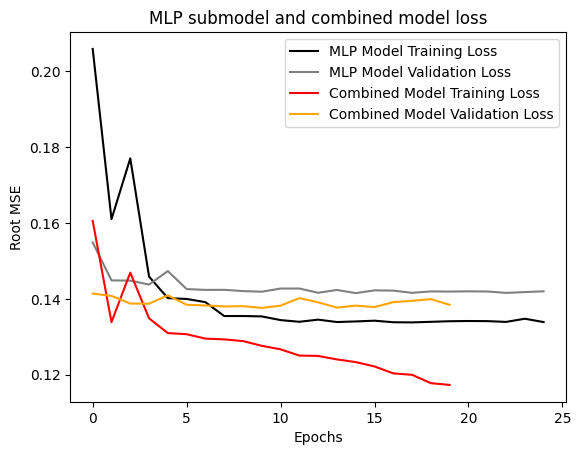

In [56]:
from matplotlib import pyplot as plt

mlp_history_dict = mlp_history.history
mlp_loss_hist = mlp_history_dict['root_mean_squared_error']
mlp_val_loss_hist = mlp_history_dict['val_root_mean_squared_error']
mlp_n = len(mlp_loss_hist)

history_dict = history.history
loss_hist = history_dict['root_mean_squared_error']
val_loss_hist = history_dict['val_root_mean_squared_error']
n = len(loss_hist)

# Disclaimer: I have no idea about color theory

# plot mlp model performace
plt.plot(range(mlp_n), mlp_loss_hist, 'black', label='MLP Model Training Loss')
plt.plot(range(mlp_n), mlp_val_loss_hist, 'grey', label='MLP Model Validation Loss')

# plot combined model performance
plt.plot(range(n), loss_hist, 'red', label='Combined Model Training Loss')
plt.plot(range(n), val_loss_hist, 'orange', label='Combined Model Validation Loss')
plt.title('MLP submodel and combined model loss')
plt.xlabel('Epochs')
plt.ylabel('Root MSE')
plt.legend()


plt.show()

We can see that training does occur, but the model overfits quite rapidly (training loss keeps decreasing while validation loss fluctuates around a constant point). Since we have already introduced various regularization techniques in our model, it is possible that the model suffers from insufficient data and can't infer more robust patterns from them.

We also observe that the combined model's validation loss is consistenly lower than the MLP's, indicating our model does indeed find useful patterns in the abstract's text.

In order to evaluate the performance of our model we will use the root mean squared loss of the test set:

In [49]:
print("Running the combined model on test data...")
test_results = mlp.evaluate(attr_test, y_test)
print(f" Test MSE:{test_results[0]} Test Squared MSE: {test_results[1]}")

Running the combined model on test data...
71/71 [==============================] - 0s 1ms/step - loss: 0.0171 - root_mean_squared_error: 0.1307
 Test MSE:0.01709374412894249 Test Squared MSE: 0.13074304163455963


We can see that our combined model performs significantly better than our simple MLP model. This would indicate that it does indeed find some useful patterns among the papers' abstract.

We will now create a dummy regression model which simply only guesses the mean of the CD5 index for any paper. 

This estimator essentially only uses the prior knowledge of the sampled distribution (which due to the size of the training dataset should be almost identical to the one in the test dataset), ignoring all of its features. 

In [50]:
from sklearn.metrics import mean_squared_error

cd_mean = y_train.mean()
y_pred = np.full(y_train.shape, cd_mean)
mse = mean_squared_error(y_train, y_pred, squared=True)
rmse = mean_squared_error(y_train, y_pred, squared=False)
print(f" Dummy MSE: {mse}\nDummy Root MSE: {rmse}")

 Dummy MSE: 0.018333767510418285
Dummy Root MSE: 0.13540224337291568


It is evident that our model does indeed perform better than the dummy classifier, since its test loss is lower than the latters'.

We can also look at the models' predictions to determine if they are logical (e.g they are not all the same value or very close to the training sample mean). 

In [51]:
print("Generate predictions for test data:")
test_predictions = model.predict([attr_test, text_test])
test_predictions

Generate predictions for test data:
71/71 [==============================] - 0s 4ms/step


array([[-0.00787711],
       [ 0.04754507],
       [-0.00961481],
       ...,
       [-0.00488754],
       [-0.00550855],
       [-0.00730866]], dtype=float32)

In [52]:
print(f"Notebook executed in {(time() - start_time)/60 :.3f} minutes.")

Notebook executed in 9.782 minutes.
